# Vehicle Detection

Find vehicles in videos

## Lesson functions
These functions are from the lesson on object detection so I'm importing them verbatim


In [3]:
import numpy as np
import matplotlib.image as mpimg
import cv2
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        file_features = single_img_features(image, color_space=color_space, spatial_size=spatial_size,
                                           hist_bins=hist_bins, orient=orient,
                                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                           hog_channel=hog_channel, spatial_feat=spatial_feat,
                                           hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(file_features)
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



## Extract features

First, extract features. The below is also from the lesson.

In [4]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Read in cars and notcars
cars = glob.glob('training/vehicles/**/*.png',recursive=True)
notcars = glob.glob('training/non-vehicles/**/*.png',recursive=True)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
print('cars length:',len(cars))
print('notcars length:',len(notcars))
if len(cars) > len(notcars):
    sample_size = len(cars)
else:
    sample_size = len(notcars)
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


cars length: 8792
notcars length: 8968


## Training classifier

Normalize and train a linear SVM.

NOTE: I have previously repeatedly trained the classifier with a grid search for C between 0.001, 0.01, 1, 10, 100, 1000. Each time C was 10, so I have now dropped the other params. 

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Removed because I am not changing features and had to retrain the SVM, but C=10 was the best value before
#parameters = {'C':[0.001, 0.01, 1, 10, 100, 1000]}
parameters = {'C':[10]}
svr = svm.SVC()
clf = GridSearchCV(svr, parameters, n_jobs=6)

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
print('Best params ', clf.best_params_)
# Check the prediction time for a single sample
t=time.time()

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2004
171.74 Seconds to train SVC...
Test Accuracy of SVC =  0.9963
Best params  {'C': 10}


In [6]:
from sklearn.externals import joblib
joblib.dump(clf, 'clf.pickle')
joblib.dump(X_scaler, 'X_scaler.pickle')

['X_scaler.pickle']

In [5]:
from sklearn.externals import joblib
clf = joblib.load('clf.pickle')
X_scaler = joblib.load('X_scaler.pickle')

[]


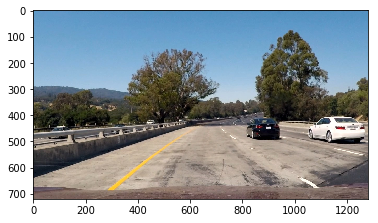

[]


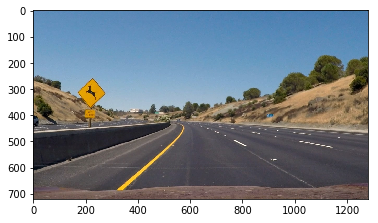

[]


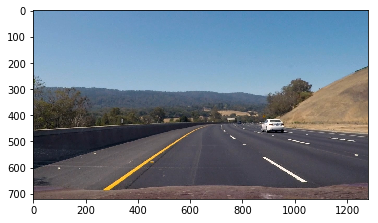

[]


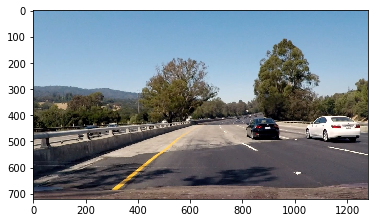

[]


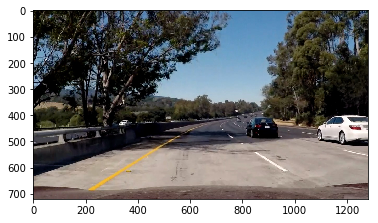

[]


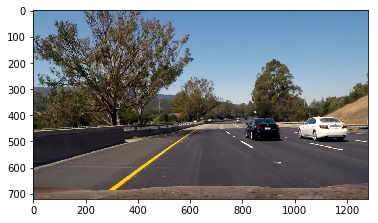

2.56 Seconds to find objects in  6  images


In [7]:
import glob
import time

tests = glob.glob('test_images/*.jpg',recursive=True)
t=time.time()
    
for test in tests:
    image = mpimg.imread(test)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    print(hot_windows)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    
    
    plt.imshow(window_img)
    plt.show()
    
t2 = time.time()
print(round(t2-t, 2), 'Seconds to find objects in ', len(tests), ' images')



test_images/test1.jpg


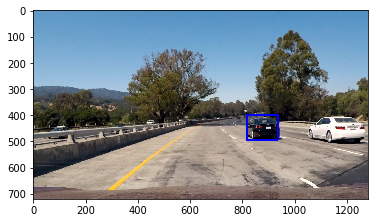

test_images/test2.jpg


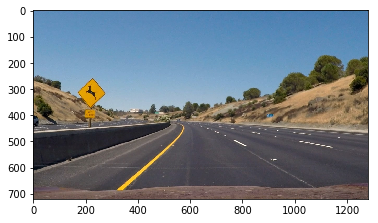

test_images/test3.jpg


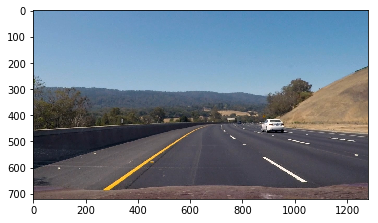

test_images/test4.jpg


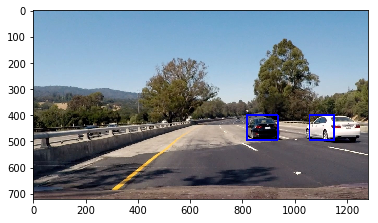

test_images/test5.jpg


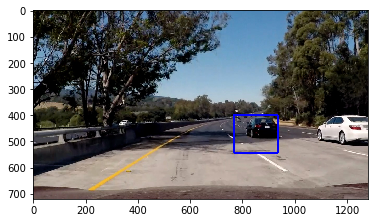

test_images/test6.jpg


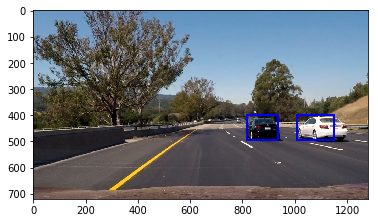

7.85 Seconds to find objects in  6  images


In [11]:
# more efficient subsampling of HoG features, computes HoG once

def detect_singleScale(img, clf, X_scaler, ystart=None, ystop=None, 
              color_space='RGB', scale=1.0, 
              spatial_size=(32, 32), hist_bins=32,
              hist_range=(0,256), orient=9,
              pix_per_cell=8, cell_per_block=2, cells_per_step=2,
              hog_channel=0, spatial_feat=True, 
              hist_feat=True, hog_feat=True):
    
    on_windows = []
    #img = img.astype(np.float32)/255
    
    ystart = 0 if ystart is None else ystart
    ystop = img.shape[0] if ystop is None else ystop
    
    img_tosearch = img[ystart:ystop,:,:]
   
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)      
    if scale != 1.0:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            #print('spatial_features:', len(spatial_features))
            #print('hist_features:', len(hist_features))
            #print('hog_features:', len(hog_features))

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))  
            #print('test_features:', test_features.shape)
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                on_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return on_windows

def detect_multiScale(img, clf, X_scaler, ystart=None, ystop=None, 
              color_space='RGB', scale=1.5, max_layers=5,
              spatial_size=(32, 32), hist_bins=32,
              hist_range=(0,256), orient=9,
              pix_per_cell=8, cell_per_block=2, cells_per_step=2,
              hog_channel=0, spatial_feat=True, 
              hist_feat=True, hog_feat=True):
    #compute multiscale steps
    window_size = 64
    current_scale = 1.5
    on_windows = []
    
    detect_args = []
    for i in range(max_layers):
        if (img.shape[0]/current_scale > window_size) or (img.shape[1]/current_scale > window_size):
            hot_windows = detect_singleScale(img, clf, X_scaler, ystart=ystart, ystop=ystop,
                              color_space=color_space, scale=current_scale,
                              spatial_size=spatial_size, hist_bins=hist_bins,
                              hist_range=hist_range, orient=orient,
                              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                              cells_per_step=cells_per_step,
                              hog_channel=hog_channel, spatial_feat=spatial_feat,
                              hist_feat=hist_feat, hog_feat=hog_feat)
            on_windows.extend(hot_windows)
        current_scale = current_scale*scale
    return on_windows

from scipy.ndimage.measurements import label
def process_image(image):
    
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    
    hot_windows = detect_multiScale(image, clf, X_scaler, ystart=400, ystop=None,
                            color_space=color_space, scale=1.5, max_layers=4,
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, cells_per_step=2,
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    return draw_img

import glob
import time

tests = glob.glob('test_images/*.jpg',recursive=True)
t=time.time()
    
for test in tests:
    print(test)
    image = mpimg.imread(test)
    draw_img = process_image(image)
    plt.imshow(draw_img)
    plt.show()
    
t2 = time.time()
print(round(t2-t, 2), 'Seconds to find objects in ', len(tests), ' images')




In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

project_video = 'project_video.mp4'
output_video = project_video.split('.')[0] + '_output.mp4'


In [30]:
import multiprocessing as mp 
from scipy.ndimage.measurements import label
from moviepy.editor import VideoClip

#These values are globals (lazy) to make it easy to debug frame extraction and generation
clip1 = VideoFileClip(project_video)
start_s = 0
end_s = clip1.duration
clip1 = clip1.subclip(start_s,end_s)


# detect windows in frames, returns windows list 
# this is used as a map on frames, so doesn't need to know about start_s and end_s
def detect_frame(image):
    image = image.astype(np.float32)/255
    hot_windows = detect_multiScale(image, clf, X_scaler, ystart=400, ystop=None,
                        color_space=color_space, scale=1.3, max_layers=5,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, cells_per_step=2,
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    return hot_windows

pool = mp.Pool(processes=6)
windows = pool.map(detect_frame, clip1.iter_frames())
pool.close()
pool.join()
pool = None
print(len(windows), ' windows found')


Exception ignored in: <bound method FFMPEG_VideoReader.__del__ of <moviepy.video.io.ffmpeg_reader.FFMPEG_VideoReader object at 0x155f84748>>
Traceback (most recent call last):
  File "/Users/kstoltz/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/moviepy/video/io/ffmpeg_reader.py", line 176, in __del__
    self.close()
  File "/Users/kstoltz/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/moviepy/video/io/ffmpeg_reader.py", line 172, in close
    self.proc.wait()
  File "/Users/kstoltz/miniconda3/envs/carnd-term1/lib/python3.5/subprocess.py", line 1658, in wait
    (pid, sts) = self._try_wait(0)
  File "/Users/kstoltz/miniconda3/envs/carnd-term1/lib/python3.5/subprocess.py", line 1608, in _try_wait
    (pid, sts) = os.waitpid(self.pid, wait_flags)
KeyboardInterrupt: 


250  windows found


In [31]:

# used as a generator for frames, needs to know about start_s and end_s (t+start_s becomes an offset)
def make_frame(t):
    image = clip1.get_frame(t)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    hot_window = windows[int(round(t*clip1.fps))]
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_window)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(image, labels)
    return draw_img
    


clip_out = VideoClip(make_frame, duration=(end_s-start_s)) # 2 seconds
clip_out.write_videofile(output_video,fps=clip1.fps, threads=4)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 250/251 [00:07<00:00, 33.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [32]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))
